<a href="https://colab.research.google.com/github/Shahid-TheMatrixMaker/100-Data-Science-Project/blob/main/Image_classification_dogs_vs_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ["KAGGLE_CONFIG_DIR"] = '/content/gdrive/MyDrive/Kaggle'

In [ ]:
%cd gdrive/MyDrive/Kaggle

[Errno 2] No such file or directory: 'gdrive/MyDrive/Kaggle'
/content/gdrive/MyDrive/Kaggle


In [ ]:
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

Dataset URL: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset
License(s): other
 99% 780M/788M [00:14<00:00, 97.4MB/s]
100% 788M/788M [00:14<00:00, 58.6MB/s]


In [ ]:
# list all files and directories in the current directory
!ls

kaggle.json  microsoft-catsvsdogs-dataset.zip


In [ ]:
!unzip microsoft-catsvsdogs-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: PetImages/Dog/550.jpg   
  inflating: PetImages/Dog/5500.jpg  
  inflating: PetImages/Dog/5501.jpg  
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   
  inflating: PetImages/Dog/5520.jpg  
  inflating: PetImages/Dog/5521.jpg  

In [ ]:
# import necessary libraries
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import plotly.express as px
import scipy as np

from scipy import ndimage
from shutil import copyfile
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
class_names = ['Cat', 'Dog']

n_dogs = len(os.listdir('/content/gdrive/MyDrive/Kaggle/PetImages/Dog'))
n_cats = len(os.listdir('/content/gdrive/MyDrive/Kaggle/PetImages/Cat'))
n_images = [n_cats, n_dogs]
px.pie(names=class_names, values=n_images)

In [ ]:
# Create the necessary directories
try:
    os.mkdir('/content/gdrive/MyDrive/Kaggle/cats-v-dogs')
    os.mkdir('/content/gdrive/MyDrive/Kaggle/cats-v-dogs/training')
    os.mkdir('/content/gdrive/MyDrive/Kaggle/cats-v-dogs/validation')
    os.mkdir('/content/gdrive/MyDrive/Kaggle/cats-v-dogs/test')
    os.mkdir('/content/gdrive/MyDrive/Kaggle/cats-v-dogs/training/cats')
    os.mkdir('/content/gdrive/MyDrive/Kaggle/cats-v-dogs/training/dogs')
    os.mkdir('/content/gdrive/MyDrive/Kaggle/cats-v-dogs/validation/cats')
    os.mkdir('/content/gdrive/MyDrive/Kaggle/cats-v-dogs/validation/dogs')
    os.mkdir('/content/gdrive/MyDrive/Kaggle/cats-v-dogs/test/cats')
    os.mkdir('/content/gdrive/MyDrive/Kaggle/cats-v-dogs/test/dogs')
except OSError:
    print('Error: Failed to create directories')

In [ ]:
def split_data(main_dir, training_dir, validation_dir, test_dir=None, include_test_split = True,  split_size=0.8):
    """
    Splits the data into train validation and test sets (optional)

    Args:
    main_dir (string):  path containing the images
    training_dir (string):  path to be used for training
    validation_dir (string):  path to be used for validation
    test_dir (string):  path to be used for test
    include_test_split (boolen):  whether to include a test split or not
    split_size (float): size of the dataset to be used for training
    """
    files = []
    for file in os.listdir(main_dir):
        if  os.path.getsize(os.path.join(main_dir, file)): # check if the file's size isn't 0
            files.append(file) # appends file name to a list

    shuffled_files = random.sample(files,  len(files)) # shuffles the data
    split = int(0.9 * len(shuffled_files)) #the training split casted into int for numeric rounding
    train = shuffled_files[:split] #training split
    split_valid_test = int(split + (len(shuffled_files)-split)/2)

    if include_test_split:
        validation = shuffled_files[split:split_valid_test] # validation split
        test = shuffled_files[split_valid_test:]
    else:
        validation = shuffled_files[split:]

    for element in train:
        copyfile(os.path.join(main_dir,  element), os.path.join(training_dir, element)) # copy files into training directory

    for element in validation:
        copyfile(os.path.join(main_dir,  element), os.path.join(validation_dir, element))# copy files into validation directory

    if include_test_split:
        for element in test:
            copyfile(os.path.join(main_dir,  element), os.path.join(test_dir, element)) # copy files into test directory
    print("Split sucessful!")

In [ ]:
#Define data path
CAT_DIR = '/content/gdrive/MyDrive/Kaggle/PetImages/Cat'
DOG_DIR = '/content/gdrive/MyDrive/Kaggle/PetImages/Dog'

TRAINING_DIR = "/content/gdrive/MyDrive/Kaggle/cats-v-dogs/training/"
VALIDATION_DIR = "/content/gdrive/MyDrive/Kaggle/cats-v-dogs/validation/"

TRAINING_CATS = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS = os.path.join(VALIDATION_DIR, "dogs/")

# Define whether to include test split or not
INCLUDE_TEST = True

In [ ]:
split_data('/content/gdrive/MyDrive/Kaggle/PetImages/Cat',
           '/content/gdrive/MyDrive/Kaggle/cats-v-dogs/training/cats',
           '/content/gdrive/MyDrive/Kaggle/cats-v-dogs/validation/cats',
           '/content/gdrive/MyDrive/Kaggle/cats-v-dogs/test/cats', INCLUDE_TEST, 0.8)
split_data('/content/gdrive/MyDrive/Kaggle/PetImages/Dog',
           '/content/gdrive/MyDrive/Kaggle/cats-v-dogs/training/dogs',
           '/content/gdrive/MyDrive/Kaggle/cats-v-dogs/validation/dogs',
           '/content/gdrive/MyDrive/Kaggle/cats-v-dogs/test/dogs', INCLUDE_TEST, 0.8)

Split sucessful!
Split sucessful!


In [ ]:
print(len(os.listdir('/content/gdrive/MyDrive/Kaggle/cats-v-dogs/training/cats')))
print(len(os.listdir('/content/gdrive/MyDrive/Kaggle/cats-v-dogs/training/dogs')))

print(len(os.listdir('/content/gdrive/MyDrive/Kaggle/cats-v-dogs/validation/cats')))
print(len(os.listdir('/content/gdrive/MyDrive/Kaggle/cats-v-dogs/validation/dogs')))

print(len(os.listdir('/content/gdrive/MyDrive/Kaggle/cats-v-dogs/test/cats')))
print(len(os.listdir('/content/gdrive/MyDrive/Kaggle/cats-v-dogs/test/dogs')))



11250
11250
625
625
625
625


In [ ]:
train_gen = ImageDataGenerator(
        rescale=1./255)


validation_gen =  ImageDataGenerator(
        rescale=1./255.)

if INCLUDE_TEST:
    test_gen =  ImageDataGenerator(
            rescale=1./255.)

In [ ]:
train_generator = train_gen.flow_from_directory(
        '/content/gdrive/MyDrive/Kaggle/cats-v-dogs/training',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')
validation_generator = validation_gen.flow_from_directory(
        '/content/gdrive/MyDrive/Kaggle/cats-v-dogs/validation',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

if INCLUDE_TEST:
    test_generator = test_gen.flow_from_directory(
        '/content/gdrive/MyDrive/Kaggle/cats-v-dogs//validation',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

Found 22499 images belonging to 2 classes.
Found 1249 images belonging to 2 classes.
Found 1249 images belonging to 2 classes.


In [ ]:
class_names = ['Cat', 'Dog']

def plot_data(generator, n_images):
    """
    Plots random data from dataset
    Args:
    generator: a generator instance
    n_images : number of images to plot
    """
    i = 1
    # Use next(generator) to get the next batch of images and labels
    images, labels = next(generator)
    labels = labels.astype('int32')

    plt.figure(figsize=(14, 15))

    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
        i += 1
        if i == n_images:
            break

    plt.show()

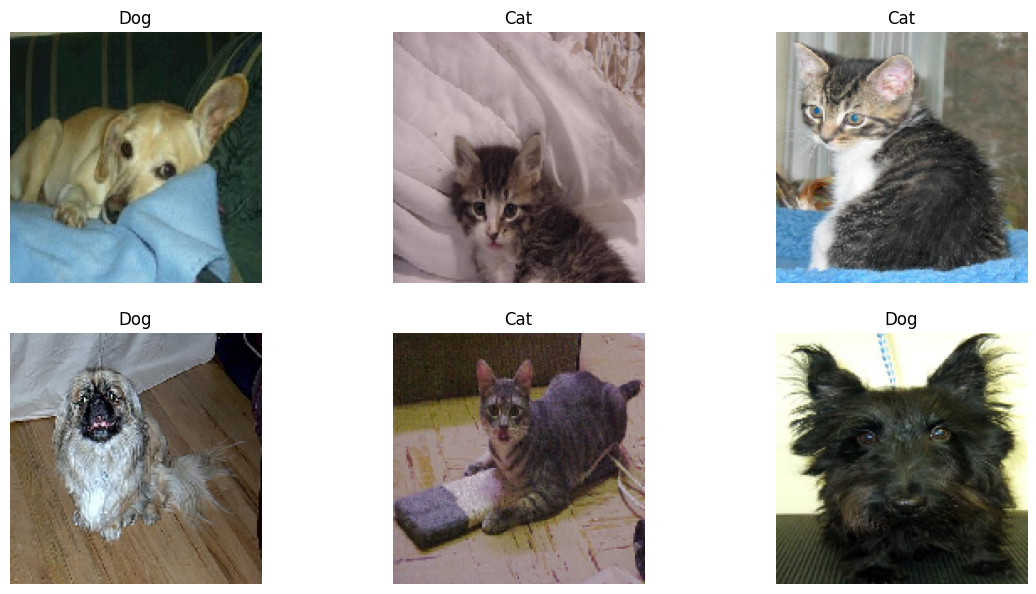

In [ ]:
plot_data(train_generator,7)

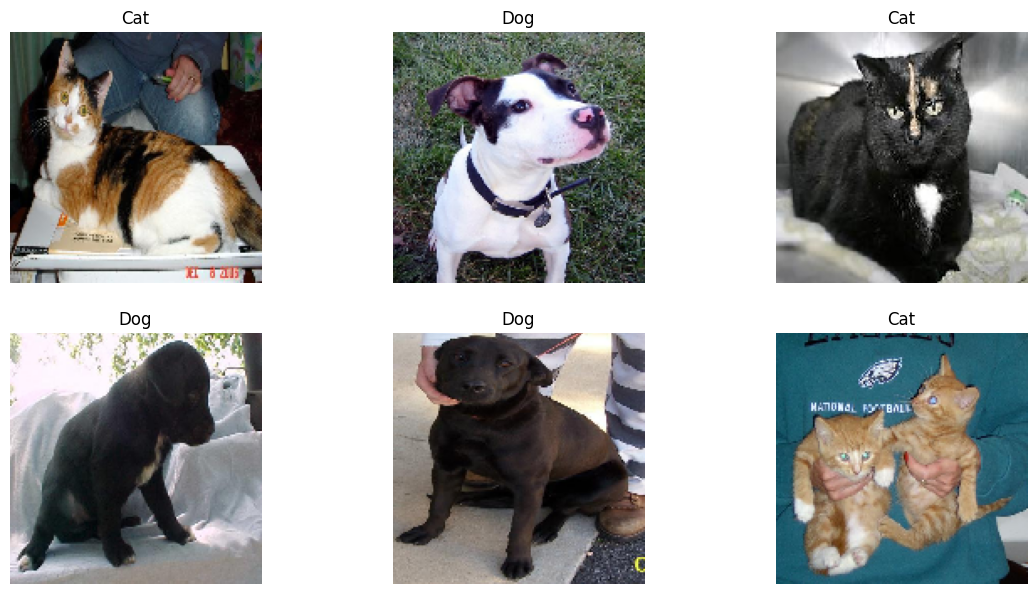

In [ ]:
plot_data(validation_generator,7)

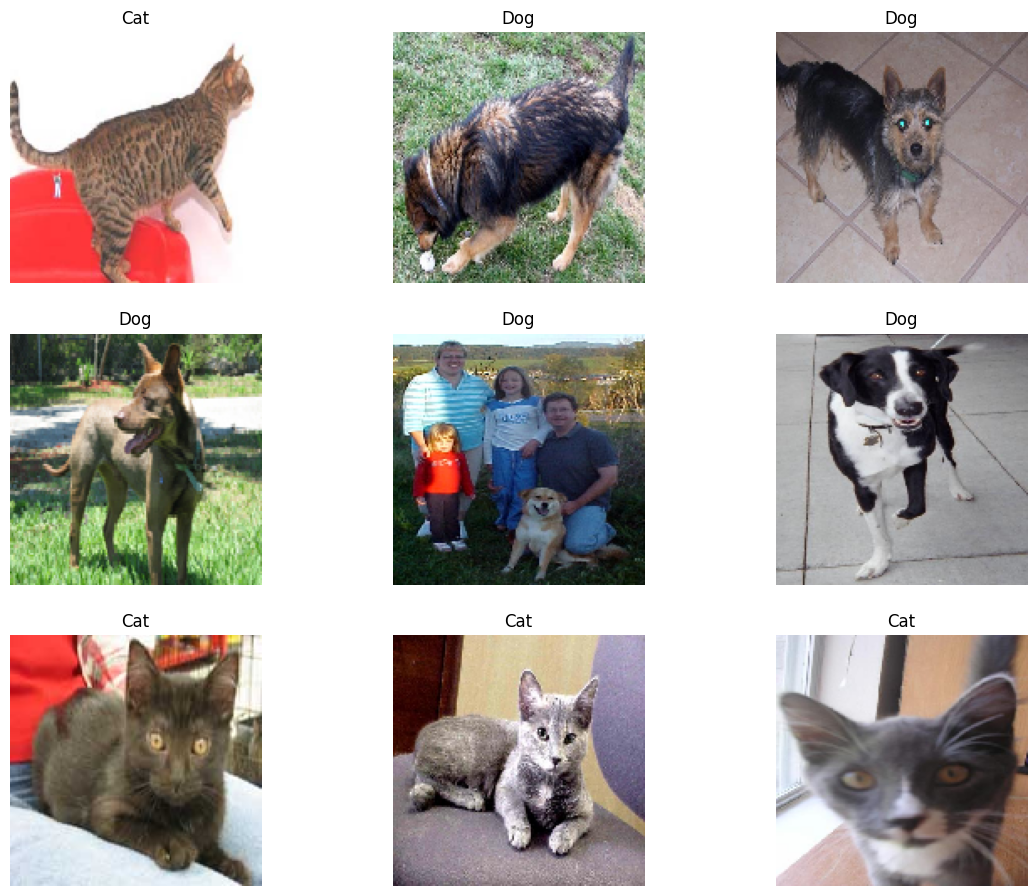

In [ ]:
if INCLUDE_TEST:
    plot_data(test_generator, 10)

In [ ]:
inputs = tf.keras.layers.Input(shape=(150,150,3))
x =  tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(256, (3,3), activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=x)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
r = model.fit(
        train_generator,
        epochs=10,#Training longer could yield better results
        validation_data=validation_generator)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



352/352 ━━━━━━━━━━━━━━━━━━━━ 5619s 16s/step - accuracy: 0.5166 - loss: 0.6916 - val_accuracy: 0.5989 - val_loss: 0.6542
Epoch 2/10
 55/352 ━━━━━━━━━━━━━━━━━━━━ 1:15:55 15s/step - accuracy: 0.6013 - loss: 0.6622

In [ ]:
if INCLUDE_TEST:
    model.evaluate(test_generator)

In [ ]:
def plot_prediction(generator, n_images):
    """
    Test the model on random predictions
    Args:
    generator: a generator instance
    n_images : number of images to plot

    """
    i = 1
    # Get the images and the labels from the generator
    images, labels = generator.next()
    # Gets the model predictions
    preds = model.predict(images)
    predictions = np.argmax(preds, axis=1)
    labels = labels.astype('int32')
    plt.figure(figsize=(14, 15))
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        if predictions[i] == labels[i]:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='g')
            plt.axis('off')
        else:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='r')
            plt.axis('off')
        i += 1
        if i == n_images:
            break

    plt.show()

In [ ]:
if INCLUDE_TEST:
    plot_prediction(test_generator, 10)

In [ ]:
# Create a  model to visualize activation maps
gp_weights =  model.get_layer('dense').get_weights()[0]
activation_model = Model(model.inputs, outputs=(model.get_layer('conv2d_5').output, model.get_layer('dense_1').output))

In [ ]:
# Use the model to make predictions on the test generator
images, _ = test_generator.next()
features, results = activation_model.predict(images)

In [ ]:
def show_cam(image_index, features, results):
    """
    Shows activation maps
    Args:
    image_index: index of image
    features: the extracted features
    results: model's predictions
    """
    # takes the features of the chosen image
    features_for_img = features[image_index,:,:,:]

    # get the class with the highest output probability
    prediction = np.argmax(results[image_index])

    # get the gap weights at the predicted class
    class_activation_weights = gp_weights[:,prediction]

    # upsample the features to the image's original size (150 x 150)
    class_activation_features = sp.ndimage.zoom(features_for_img, (150/30, 150/30, 1), order=2)

    # compute the intensity of each feature in the CAM
    cam_output  = np.dot(class_activation_features,class_activation_weights)

    print('Predicted Class = ' +str(class_names[prediction])+ ', Probability = ' + str(results[image_index][prediction]))

    # show the upsampled image

    plt.imshow(images[image_index])

    # strongly classified (95% probability) images will be in green, else red
    if results[image_index][prediction]>0.95:
        cmap_str = 'Greens'
    else:
        cmap_str = 'Blues'

    # overlay the cam output
    plt.imshow(cam_output, cmap=cmap_str, alpha=0.5)

    # display the image
    plt.show()

In [ ]:
def show_maps(desired_class, num_maps):
    '''
    goes through the first 10,000 test images and generates Cam activation maps
    Args:
    desired_class: class to show the maps for
    num_maps: number of maps to be generated
    '''
    counter = 0
    # go through the first 10000 images
    for i in range(0,10000):
        # break if we already displayed the specified number of maps
        if counter == num_maps:
            break

        # images that match the class will be shown
        if np.argmax(results[i]) == desired_class:
            counter += 1
            show_cam(i,features, results)

In [ ]:
show_maps(desired_class=1, num_maps=5)


In [ ]:
show_maps(desired_class=0, num_maps=5)

In [ ]:
# Visualize training process

results = pd.DataFrame(r.history)
results.tail()

In [ ]:
# Ploting the accuracy and validation accuracy:
fig = px.line(results,y=[results['accuracy'],results['val_accuracy']],template="seaborn",color_discrete_sequence=['#fad25a','red'])
fig.update_layout(
    title_font_color="#fad25a",
    xaxis=dict(color="#fad25a",title='Epochs'),
    yaxis=dict(color="#fad25a")

In [ ]:
# Ploting the loss and validation loss:
fig = px.line(results,y=[results['loss'],results['val_loss']],template="seaborn",color_discrete_sequence=['#fad25a','red'])
fig.update_layout(
    title_font_color="#fad25a",
    xaxis=dict(color="#fad25a",title='Epochs'),
    yaxis=dict(color="#fad25a")
 )
fig.show()

In [ ]:
# Trying Data Augmentation

train_gen_aug = ImageDataGenerator(
        rescale=1./255,fill_mode='nearest',horizontal_flip=True,
        rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
)

In [ ]:
validation_gen_aug =  ImageDataGenerator(
        rescale=1./255.)

In [ ]:
train_generator = train_gen_aug.flow_from_directory(
        '/tmp/cats-v-dogs/training',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')
validation_generator = validation_gen_aug.flow_from_directory(
        '/tmp/cats-v-dogs/validation',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

In [ ]:
inputs = tf.keras.layers.Input(shape=(150,150,3))
x =  tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(256, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)


x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)

model_aug = Model(inputs=inputs, outputs=x)

In [ ]:
model_aug.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
r = model_aug.fit(
        train_generator,
        epochs=10,#Training longer could yield better results
        validation_data=validation_generator)

In [ ]:
results = pd.DataFrame(r.history)
results.tail()


In [ ]:
fig = px.line(results,y=[results['accuracy'],results['val_accuracy']],template="seaborn",color_discrete_sequence=['#fad25a','red'])
fig.update_layout(
    title_font_color="#fad25a",
    xaxis=dict(color="#fad25a",title='Epochs'),
    yaxis=dict(color="#fad25a")
 )
fig.show()

In [ ]:
fig = px.line(results,y=[results['loss'],results['val_loss']],template="seaborn",color_discrete_sequence=['#fad25a','red'])
fig.update_layout(
    title_font_color="#fad25a",
    xaxis=dict(color="#fad25a",title='Epochs'),
    yaxis=dict(color="#fad25a")
 )
fig.show()